# Tutorial:  Training using multi-omics data

## Introduction

This tutorial demonstrates how to use **scGenAI** to train a model for predicting cell types from CITE-Seq data (RNA + ADT). In this example, we apply the **random context** method to generate input sequences.

**Note:**
1. The dataset used for this tutorial consists of **40 cells**, selected for demonstration purposes. For practical applications, it is recommended to use a larger, more representative dataset.
2. In this tutorial, we will load the model template directly from the cache folder.
3. While the model in this example is trained to predict cell types, it can be applied to predict any feature in practical applications.
4. We use the **random context** method to build the context for each cell in this tutorial. Other methods (`genomics`, `biofounction`, `genelist`) can also be applied to the same multi-omics data, as demonstrated with single-cell RNA-seq data.
5. This tutorial uses RNA and antibody (ADT) data. However, other types of multi-omics data (e.g., scATAC-Seq, MissionBio) can be used in the same way by setting one omic dataset as `train_file`, and the other as `train_ADTfile`.



## Train the Model Using CITE-Seq (Multiple GPU)

The training process can be easily initiated by calling the `run_training_from_config` function in **scGenAI**, using the input files specified in a configuration YAML file. Example template YAML files are available in the `scgenai/examples/config_templates` folder of the package. These templates provide the necessary structure for defining training parameters, model configurations, and input data locations.


In [1]:
from scGenAI.training.train import run_training_from_config

model_dir: /home/ubuntu/scgenai/examples/testrun/test1/
train_file: /home/ubuntu/scgenai/examples/data/example_train_RNA.h5ad
val_file: /home/ubuntu/scgenai/examples/data/example_val_RNA.h5ad
train_ADTfile: /home/ubuntu/scgenai/examples/data/example_train_ADT.h5ad
val_ADTfile: /home/ubuntu/scgenai/examples/data/example_val_ADT.h5ad
log_dir: /home/ubuntu/scgenai/examples/logs/
output_dir: /home/ubuntu/scgenai/examples/output
seed: 1314521
cache_dir: /home/ubuntu/scgenai/examples/tmp/cache
mode: Train
min_cells: 2
target_feature: celltype.l2
multiomics: Yes
keepIntermediateFiles: No
savelog: Yes
savesetting: Yes
model_backbone_name: llama
model_backbone_size: small
context_method: random
num_bins: 10
optimizer: AdamW
weight_decay: 0.01
depth: 2
max_length: 5120
batch_size: 1
learning_rate: 1e-05
num_epochs: 20
world_size: 1
evaluate_during_training: True
hidden_size: 256
num_layers: 6
num_heads: 4
intermediate_size: 1024
stride: 2560


2024-10-16 00:45:11.150 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 0, Total GPUs used: 4
2024-10-16 00:45:11.159 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 1, Total GPUs used: 4
2024-10-16 00:45:11.163 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 3, Total GPUs used: 4
2024-10-16 00:45:11.165 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 2, Total GPUs used: 4
2024-10-16 00:45:13.393 | INFO     | scGenAI.training.train:model_train_and_eval:214 - Total number of trainable parameters: 75949828; Max Sequence Legth: 2560 genes
Epoch 1/20: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s, GPU_ID=0, train_accuracy=0.357, train_loss=1.39]

Evaluating Epoch 1/20: 100%|██████████| 54/54 [00:11<00:00,  4.53it/s]
2024-10-16 00:45:36.342 | INFO     | scGenAI.training.train:evaluate_and_save_pre

Plot saved to /home/ubuntu/scgenai/examples/testrun/test1/train_summary.pdf


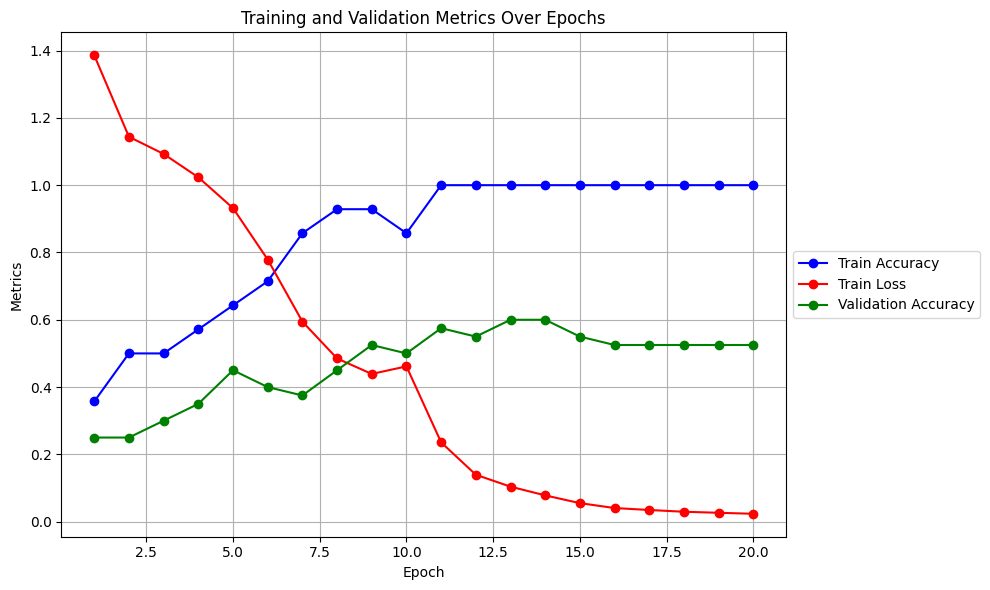

In [2]:
config_file = '/home/ubuntu/scgenai/tutorials/yaml/config_Train_MultiOmicsData_template.yaml'
run_training_from_config(config_file)

## Post-Training Model and Results

Upon completion of the training, the trained model will be saved in the `model_dir` as defined in the configuration file. Within this directory, two subfolders will be created: `best_model` and `last_model`. The `best_model` folder contains the model that achieved the highest training performance, while the `last_model` contains the model from the final epoch. Additionally, a `combined_epoch_results.csv` file will be generated in the `model_dir`, summarizing the training performance metrics across all epochs.

### Training Summary

In addition to the output summary files generated after training, the training summary can be directly accessed in Python by loading the saved configuration file.


In [7]:
from scGenAI.config import Config
from scGenAI.data.postprocess import TrainSummary

In [4]:
config = Config(config_file)
summary = TrainSummary(config.model_dir)
dfsummary = summary.table()
dfsummary

,Epoch,Validation Accuracy,Train Loss,Train Accuracy
0,1,0.250,1.386040,0.357143
1,2,0.250,1.143852,0.500000
2,3,0.300,1.092779,0.500000
3,4,0.350,1.023429,0.571429
4,5,0.450,0.931778,0.642857
5,6,0.400,0.779091,0.714286
6,7,0.375,0.594540,0.857143
7,8,0.450,0.485034,0.928571
8,9,0.525,0.438986,0.928571
9,10,0.500,0.461559,0.857143


It can also be plotted using the `summary.plot`:

Plot saved to /home/ubuntu/scgenai/examples/testrun/test1/train_summary.pdf


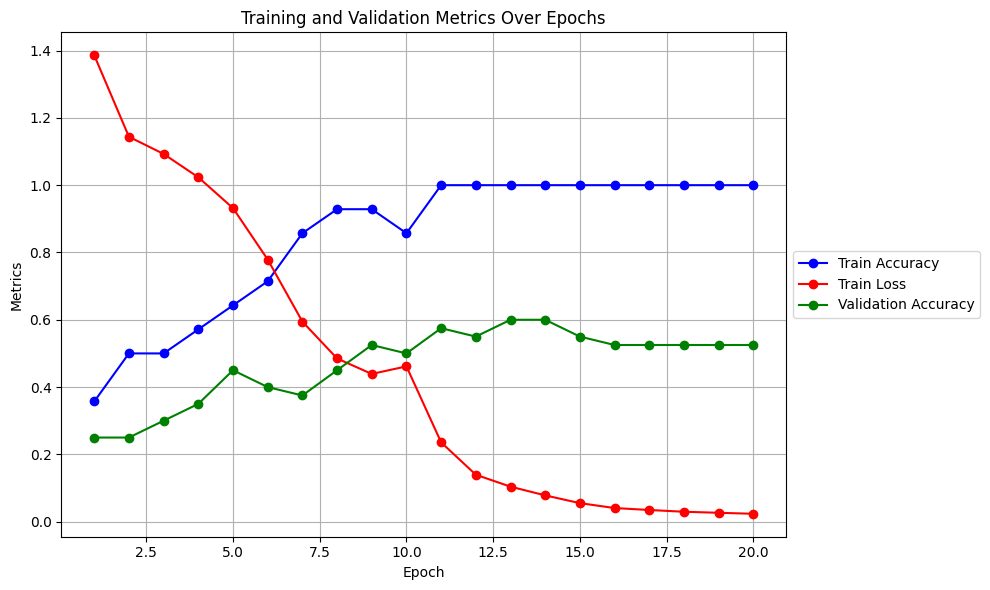

In [5]:
summary.plot(saveplot=True)

## Prediction Using the Trained Model

Similar to the training step, predictions can be run using the `run_prediction_from_config` function in scGenAI with a simple configuration file. Unlike the training configuration, the prediction configuration file only requires the following parameters to be defined: `mode`, `predict_file`, `batch_size`, `model_dir`, and `outputfile`. All other parameters will be adopted from the trained model.


In [4]:
from scGenAI.prediction.predict import run_prediction_from_config

In [5]:
pred_config_file = '/home/ubuntu/scgenai/tutorials/yaml/config_prediction_multiOmic_template.yaml'
run_prediction_from_config(pred_config_file)

model_dir: /home/ubuntu/scgenai/examples/testrun/test1/best_model/
predict_file: /home/ubuntu/scgenai/examples/data/example_val_RNA.h5ad
predict_ADTfile: /home/ubuntu/scgenai/examples/data/example_val_ADT.h5ad
log_dir: /home/ubuntu/scgenai/examples/logs
output_dir: /home/ubuntu/scgenai/examples/output
seed: 1314521
mode: Predict
min_cells: 2
multiomics: Yes
keepIntermediateFiles: No
savelog: No
savesetting: Yes
model_backbone_name: llama
model_backbone_size: small
context_method: random
num_bins: 10
optimizer: AdamW
weight_decay: 0.01
depth: 2
max_length: 5120
batch_size: 1
learning_rate: 1e-05
num_epochs: 30
world_size: 1
evaluate_during_training: False
hidden_size: 768
num_layers: 12
num_heads: 12
intermediate_size: 1024
stride: 2560


2024-10-16 01:02:00.156 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 0, Total GPUs used: 4
2024-10-16 01:02:00.159 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 3, Total GPUs used: 4
2024-10-16 01:02:00.164 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 1, Total GPUs used: 4
2024-10-16 01:02:00.182 | INFO     | scGenAI.utils.distributed:setup_distributed:26 - Distributed setup complete for GPU 2, Total GPUs used: 4
GPU 3 Predicting: 100%|██████████| 14/14 [00:03<00:00,  3.84it/s]
2024-10-16 01:02:06.984 | INFO     | scGenAI.utils.distributed:cleanup:33 - Cleaned up DDP environment
2024-10-16 01:02:06.984 | INFO     | scGenAI.utils.distributed:cleanup:33 - Cleaned up DDP environment
2024-10-16 01:02:06.984 | INFO     | scGenAI.utils.distributed:cleanup:33 - Cleaned up DDP environment
2024-10-16 01:02:06.984 | INFO     | scGenAI.utils.di

The prediction output is a CSV file, as defined in the configuration file. It contains the original metadata extracted from the input prediction file (`obs` slot) along with three additional columns: `context_id`, `PredictedFeature`, and `prediction_score`. 

- `context_id` represents the context used to determine the prediction for the corresponding cell. 
- `PredictedFeature` is the final predicted feature for the cell using the trained model. 
- `prediction_score` indicates the confidence level of the prediction, with a maximum value of 1.

For example in this tutorials:

In [8]:
import pandas as pd
preconfig = Config(pred_config_file)
dfprediction = pd.read_csv(preconfig.outputfile)
dfprediction.head()

,index,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,orig.ident,lane,donor,time,celltype.l1,celltype.l2,celltype.l3,Phase,nCount_SCT,nFeature_SCT,X_index,cell_barcode,context_id,PredictedFeature,prediction_score
0,L1_TTCGATTCACGCAAAG,3699.0,208,4160.0,1222,P1_3,L1,P1,3,CD4 T,CD4 Naive,CD4 Naive,S,4716.0,1221,L1_TTCGATTCACGCAAAG,L1_TTCGATTCACGCAAAG,2_L1_TTCGATTCACGCAAAG_window_0,CD4 TCM,0.744267
1,L1_TTGCATTCACGCTGTG,5065.0,221,4309.0,1299,P3_3,L1,P3,3,CD4 T,CD4 Naive,CD4 Naive,S,4999.0,1298,L1_TTGCATTCACGCTGTG,L1_TTGCATTCACGCTGTG,1_L1_TTGCATTCACGCTGTG_window_1,CD4 Naive,0.548168
2,L1_ACGCACGAGTACGTCT,4719.0,206,4091.0,1161,P4_7,L1,P4,7,CD4 T,CD4 Naive,CD4 Naive,G1,4917.0,1159,L1_ACGCACGAGTACGTCT,L1_ACGCACGAGTACGTCT,0_L1_ACGCACGAGTACGTCT_window_2,CD8 Naive,0.820172
3,L1_TAATTCCGTAGAATGT,3702.0,209,5451.0,1447,P1_3,L1,P1,3,CD4 T,CD4 Naive,CD4 Naive,S,5332.0,1446,L1_TAATTCCGTAGAATGT,L1_TAATTCCGTAGAATGT,2_L1_TAATTCCGTAGAATGT_window_3,CD4 TCM,0.712681
4,L1_CCCAACTTCTCCTACG,5676.0,215,5087.0,1500,P2_3,L1,P2,3,CD4 T,CD4 Naive,CD4 Naive,G1,5123.0,1498,L1_CCCAACTTCTCCTACG,L1_CCCAACTTCTCCTACG,0_L1_CCCAACTTCTCCTACG_window_4,CD4 TCM,0.928588
